# Supervised MIDAA Model (CLEAN) with Treatment Classification
This notebook runs a supervised MIDAA model on the balanced dataset, leveraging the treatment labels in the AnnData object as targets for a classification loss. The classification loss is combined with the MIDAA loss for joint training.

In [1]:
import midaa as maa
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
if device.type == 'cuda':
    torch.set_default_dtype(torch.float32)

Using device: cuda


In [ ]:
# Load AnnData 
adata_path = r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Data\Antibiotic resistance\BacDrop\further processing\random_adata_balanced.h5ad" #update if needed
assert os.path.exists(adata_path), f'File not found: {adata_path}'
adata = sc.read_h5ad(adata_path)
print(f'Loaded AnnData with shape: {adata.shape}')

Loaded AnnData with shape: (11493, 4514)


In [ ]:
# Prepare treatment labels as a side matrix for classification loss
from sklearn.preprocessing import LabelBinarizer

treatment_labels = adata.obs['treatment'].astype(str).values
lb = LabelBinarizer()
y_onehot = lb.fit_transform(treatment_labels)
if y_onehot.shape[1] == 1:  # binary case
    y_onehot = np.hstack([1 - y_onehot, y_onehot])
side_matrices = [y_onehot.astype(np.float32)]
input_types_side = ["C"]

print(f'Classes: {le.classes_}')

In [ ]:
# Prepare MIDAA input
input_data_raw, normalization_raw, input_distribution = maa.get_input_params_adata(adata)

def scipy_to_torch_sparse(csr_mat, device):
    coo = csr_mat.tocoo()
    indices = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long, device=device)
    values = torch.tensor(coo.data, dtype=torch.float32, device=device)
    shape = coo.shape
    return torch.sparse_coo_tensor(indices, values, shape).coalesce()

def convert_input_list(data_list):
    torch_list = []
    for x in data_list:
        if issparse(x):
            torch_list.append(scipy_to_torch_sparse(x, device))
        else:
            if isinstance(x, torch.Tensor):
                torch_list.append(x.to(device=device, dtype=torch.float32))
            else:
                torch_list.append(torch.tensor(x, dtype=torch.float32, device=device))
    return torch_list

input_data = convert_input_list(input_data_raw)
normalization = convert_input_list(normalization_raw)

In [ ]:
# Hyperparameters
MULT = 4  # Network width multiplier to easily scale 
archetype_range = range(2, 10)  # change range as needed 
steps = 2000  # training steps 
lr = 5e-4  #  learning rate
batch_size = 4096  # batch size
torch_seed = 42  # for reproducibility
results = {}

In [ ]:
# Ensure cuda is being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# make GPU the default for all new tensors
if device.type == "cuda":
    # Any torch.tensor(...) from now on will live on cuda:0
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [ ]:
#Run MIDAA for a range of archetypes
for narchetypes in archetype_range:
    print([x.device for x in input_data])
    print([x.device for x in normalization])
    print(f'\n--- Training with {narchetypes} archetypes ---')
    result = maa.fit_MIDAA(
        input_data,
        normalization,
        input_distribution,
        side_matrices=side_matrices, #newinput for classification loss
        input_types_side=input_types_side,
        hidden_dims_dec_common=[64 * MULT, 128 * MULT],
        hidden_dims_dec_last=[256 * MULT],
        hidden_dims_enc_ind=[128 * MULT],
        hidden_dims_enc_common=[64 * MULT],
        hidden_dims_enc_pre_Z=[32 * MULT],
        lr=lr,
        gamma_lr=0.1,
        steps=steps,
        narchetypes=narchetypes,
        batch_size=batch_size,
        torch_seed=torch_seed,
        CUDA=(device.type == 'cuda'),
        just_VAE=False
    )
    results[narchetypes] = result  # Save the full result dict!
    print(f'Final ELBO for {narchetypes} archetypes: {result["ELBO"][-1]:.2f}')

Evaluating classification accuracy (unsure if this is approrpaite to keep as doesnt have an alternative for the unsupervised model)

In [ ]:
# Get predicted probabilities for the side matrix (classification)
A, B, Z = result['deepAA_obj'].encoder(input_data)
# The decoder returns (input_reconstructed, side_reconstructed)
_, side_reconstructed = result['deepAA_obj'].decoder(Z)
# side_reconstructed[0] shape: (n_samples, n_classes)
pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
pred_labels = pred_probs.argmax(axis=1)
true_labels = lb.transform(adata.obs['treatment'].astype(str).values).argmax(axis=1)
acc = (pred_labels == true_labels).mean()
print(f"Classification accuracy (MIDAA built-in): {acc:.4f}")

In [ ]:
# Plot ELBO curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for narchetypes, result in results.items():
    plt.plot(result['ELBO'], label=f'{narchetypes} archetypes')
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO curves for different archetype numbers')
plt.legend()
plt.show()

In [ ]:
#plot final ELBO for each archetype
final_elbos = {narchetypes: result['ELBO'][-1] for narchetypes, result in results.items()}
plt.figure(figsize=(8, 5))
plt.plot(list(final_elbos.keys()), list(final_elbos.values()), marker='o')
plt.xlabel('Number of archetypes')
plt.ylabel('Final ELBO')
plt.title('Final ELBO for each archetype number')
plt.show()

## Model Selection
You can select the best number of archetypes based on the ELBO curve and downstream biological interpretability.

In [5]:
import pickle
import torch

# Find the best model (elbow from elbo plot)
best_narch = [5] #defined by the user 
print(f"Best number of archetypes: {best_narch}")

# Save the result dictionary for the best model
best_result = results[best_narch]
with open(f"best_midaa_result_{best_narch}arch.pkl", "wb") as f:
    pickle.dump(best_result, f)

# Save the model state dict (model weights)
if "deepAA_obj" in best_result:
    torch.save(best_result["deepAA_obj"].state_dict(), f"best_midaa_model_{best_narch}arch.pth")

Best number of archetypes: [5]


NameError: name 'results' is not defined

In [4]:
#reloading outputs of old model
import pickle

# Load the metadata/results dictionary
with open(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\supervised_best_midaa_result_5arch_1607.pkl", "rb") as f:
    metadata = pickle.load(f)

# Access the outputs
inferred_quantities = metadata["inferred_quantities"]  # e.g., A, B, Z matrices
ELBO = metadata["ELBO"]
hyperparameters = metadata["hyperparameters"]

# get the archetype assignment matrix A
A = inferred_quantities["A"]
B = inferred_quantities["B"]
Z = inferred_quantities["Z"]


In [5]:
#importing everything at once 
import pickle

with open(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\supervised_best_midaa_result_5arch_1607.pkl", "rb") as f:
    best_result = pickle.load(f)

## Post processing 
1. Completing p-value analysis
2. Genetic analysis of archetypes


In [6]:
#leveraging functinos developed for this purpose in AA_downstream_analysis.py
import sys
sys.path.append(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Analysis")
import AA_downstream_analysis
from AA_downstream_analysis import compute_simplex_volume, compute_convex_hull_volume, randomize_Z, null_t_ratios


### 1. Completing p-value analysis

#### a. Archetype coordinates in latent space 
Using a numpy function for linear least squares problem to solve for the arcehtypes coordinate in latent space. 

In [7]:
# Solve for archetype coordinates in latent space
# This solves Z = A @ archetypes_latent for archetypes_latent
archetypes_latent, residuals, rank, s = np.linalg.lstsq(A, Z, rcond=None) #rcond=None to use default machine prevision for cutting of singular values for psuedo inverse of A

print("Archetype coordinates in latent space (shape: n_archetypes x latent_dim):")
print(archetypes_latent)
print(archetypes_latent.shape) #should be num of archetypes x latent dim, where latent dim is num of arhcetypes - 1

Archetype coordinates in latent space (shape: n_archetypes x latent_dim):
[[ 1.8841667   2.1641493   1.7198037  -1.6329664 ]
 [-0.16726646  0.03700388 -1.7748604   2.2030907 ]
 [ 0.23561369 -1.0015976  -0.54668546 -0.8525676 ]
 [-0.8290248   0.7292626  -0.01524872  0.08133085]
 [-0.09539893 -0.6821289   0.8990581   0.24221352]]
(5, 4)


#### b. Calculating the real simplex volume in latent space
Based on the same code that ParTI does to calculate the simplex volume in findMinSimplex.m function

In [8]:
# archetypes_latent: (N, d) where N = n_archetypes, d = latent_dim (should be N-1 for a full simplex)
real_simplex_volume = compute_simplex_volume(archetypes_latent)

print("Real simplex volume:", real_simplex_volume)


Real simplex volume: 1.3134868144989014


#### c. calculating the complex hull of the original data in latent space
Leveraging the Z matrix generated by MIDAA.fit, and using convexhull functions from scipy to calculate the volume

In [20]:
# Calculate the convex hull and its volume
real_convex_hull_volume = compute_convex_hull_volume(Z)

print("Convex hull volume of the data in latent space:", convex_hull_volume)

Convex hull volume of the data in latent space: 3.1962337945633372


#### d. calculate real t-ratio
Equivalent to ParTI: simplex vol / convex hull vol

In [10]:
tRatioReal = real_simplex_volume / convex_hull_volume
print ("tRatioReal: ", tRatioReal)

tRatioReal:  0.41094829068295585


#### e. calculating randomised t-ratios in latent space
Match to ParTI method:
1. Randomly permute data along each latent dimensions independently 
2.Fit the polytope (keeping # arhcetypes the same) on the randomised data 
3. calculate t-ratio for the randomised dataset 
4. repeat 10000 times to create a distribution

In [11]:
n_random = 10000
t_ratios_null = null_t_ratios(A, Z, n_random=n_random)

In [15]:
def null_t_ratios_QC(A, Z, n_random=1000): 
    t_ratios = []
    simplex_vols = []
    hull_vols = []
    n_archetypes = A.shape[1]
    for _ in range(n_random):
        # Randomise the latent space
        Z_rand = randomize_Z(Z)
        # Solve for new archetype coordinates in the randomised latent space for the same A and number of archetypes
        archetypes_latent_rand, *_ = np.linalg.lstsq(A, Z_rand, rcond=None) #solved using least squares, same as the real t-ratio model

        ########### QC on the randomised latent space ###########
        # Check if the randomly generated latent space is not the expected dimension
        if Z_rand.shape[1] != A.shape[1]-1:
            print(f"Error: Randomly generated latent space has dimension {Z_rand.shape[1]}, expected {A.shape[1]-1}.")
        
        if np.linalg.matrix_rank(archetypes_latent_rand) < archetypes_latent_rand.shape[1]:
            # Degenerate simplex, skip or set t-ratio to np.nan
            print("Degenerate simplex")
            t_ratios.append(np.nan)
            simplex_vols.append(np.nan)
            hull_vols.append(np.nan)
            continue
        #########################################################

        # Simplex volume
        simplex_vol = compute_simplex_volume(archetypes_latent_rand)
        # Convex hull volume
        hull_vol = compute_convex_hull_volume(Z_rand)
        # t-ratio
        t_ratios.append(simplex_vol / hull_vol) #simplex over convex hull
        simplex_vols.append(simplex_vol)
        hull_vols.append(hull_vol)

    return t_ratios, simplex_vols, hull_vols, Z_rand, archetypes_latent_rand

In [16]:
n_random = 1000
t_ratios_null, simplex_vols_null, hull_vols_null, Z_rand, archetypes_latent_rand = null_t_ratios_QC(A, Z, n_random=n_random)

#### f. Calculating the p value 
Given MIDAA's volume is smaller than the convex hull for the simplex, extreme values of t are taken as ones that are larger (Closer to 1)


In [12]:
#using mean to get the p-value
p_value = np.mean(t_ratios_null >= tRatioReal)
print(f"p-value: {p_value:.100f}")

p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


### Assessing process through visualisation


Visualising position of real t-ratio in the null distribution via histogram

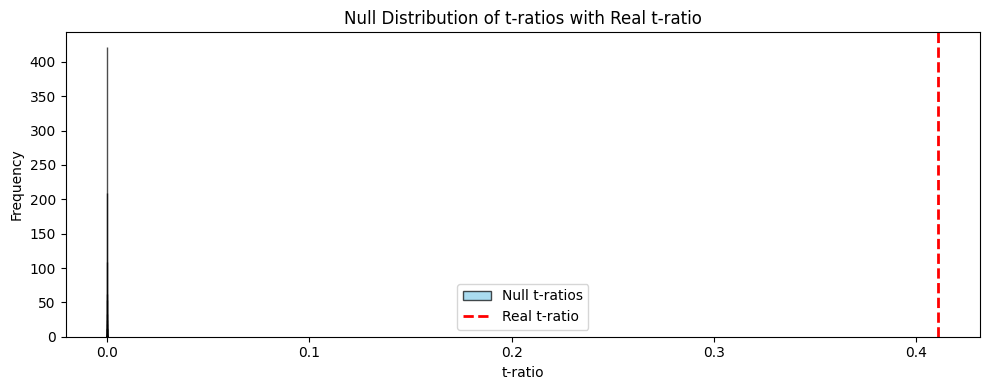

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(t_ratios_null, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Null t-ratios')
plt.axvline(tRatioReal, color='red', linestyle='dashed', linewidth=2, label='Real t-ratio')
plt.xlabel('t-ratio')
plt.ylabel('Frequency')
plt.title('Null Distribution of t-ratios with Real t-ratio')
plt.legend()
plt.tight_layout()
plt.show()


Plotting distribution of random vs real convex hull and simplex volumes

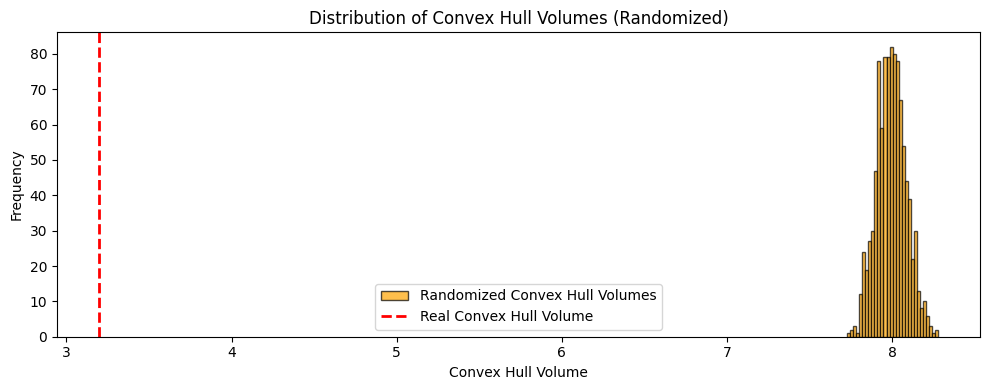

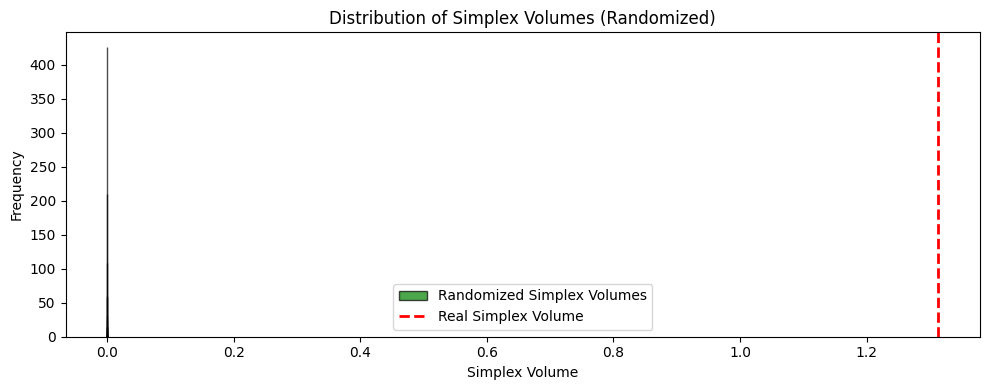

In [21]:
    # Plot the distribution of convex hull volumes with real value

    valid_hull_vols = hull_vols_null

    plt.figure(figsize=(10,4))
    plt.hist(valid_hull_vols, bins=30, color='orange', edgecolor='black', alpha=0.7, label='Randomized Convex Hull Volumes')
    plt.axvline(real_convex_hull_volume, color='red', linestyle='dashed', linewidth=2, label='Real Convex Hull Volume')
    plt.xlabel('Convex Hull Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Convex Hull Volumes (Randomized)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot the distribution of simplex volumes with real value
    valid_simplex_vols = simplex_vols_null
    plt.figure(figsize=(10,4))
    plt.hist(valid_simplex_vols, bins=30, color='green', edgecolor='black', alpha=0.7, label='Randomized Simplex Volumes')
    plt.axvline(real_simplex_volume, color='red', linestyle='dashed', linewidth=2, label='Real Simplex Volume')
    plt.xlabel('Simplex Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Simplex Volumes (Randomized)')
    plt.legend()
    plt.tight_layout()
    plt.show()


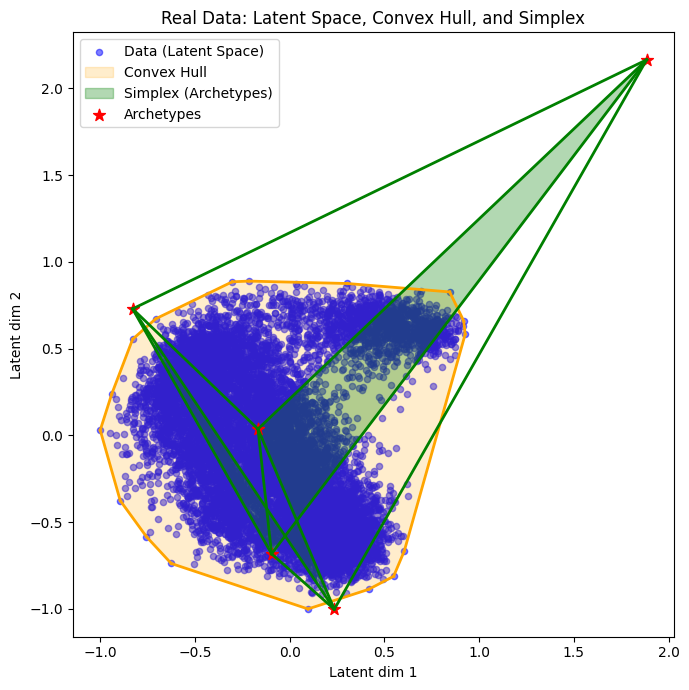

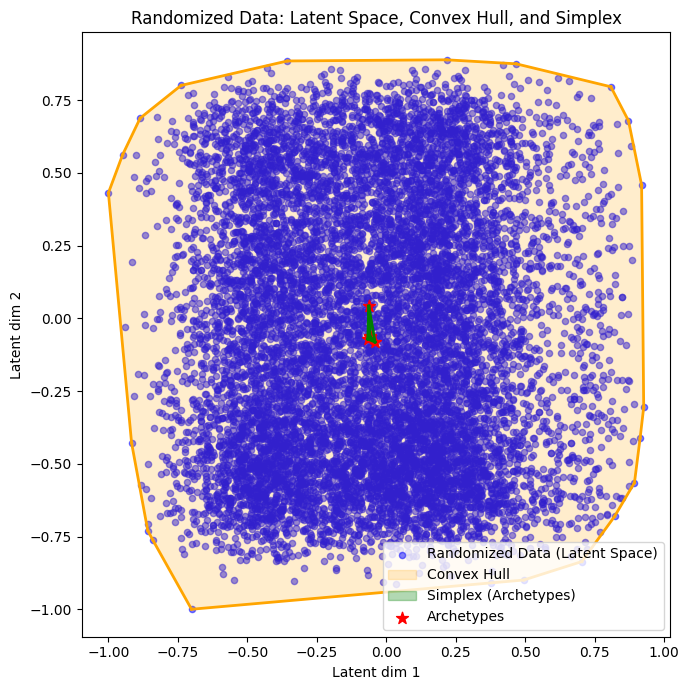

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Helper function to plot convex hull
def plot_convex_hull(ax, points, hull, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull'):
    for simplex in hull.simplices:
        simplex_points = points[simplex]
        ax.plot(simplex_points[:, 0], simplex_points[:, 1], '-', color=edgecolor, lw=2)
    # Fill the hull
    hull_path = points[hull.vertices]
    ax.fill(hull_path[:, 0], hull_path[:, 1], color=color, alpha=alpha, label=label)

# Helper function to plot simplex
def plot_simplex(ax, simplex_points, color='green', alpha=0.3, edgecolor='green', label='Simplex'):
    # Draw lines between all pairs of simplex vertices
    n = simplex_points.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            ax.plot([simplex_points[i, 0], simplex_points[j, 0]],
                    [simplex_points[i, 1], simplex_points[j, 1]],
                    color=edgecolor, lw=2)
    # Fill the simplex
    ax.fill(simplex_points[:, 0], simplex_points[:, 1], color=color, alpha=alpha, label=label)

# --- Plot for real data ---
# Project to first 2 latent dimensions
Z_2d = Z[:, :2]
archetypes_latent_2d = archetypes_latent[:, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(Z_2d[:, 0], Z_2d[:, 1], s=20, color='blue', alpha=0.5, label='Data (Latent Space)')
# Convex hull
hull_real = ConvexHull(Z_2d)
plot_convex_hull(ax, Z_2d, hull_real, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull')
# Simplex (archetypes)
plot_simplex(ax, archetypes_latent_2d, color='green', alpha=0.3, edgecolor='green', label='Simplex (Archetypes)')
ax.scatter(archetypes_latent_2d[:, 0], archetypes_latent_2d[:, 1], color='red', s=80, marker='*', label='Archetypes')
ax.set_title('Real Data: Latent Space, Convex Hull, and Simplex')
ax.legend()
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.tight_layout()
plt.show()

# --- Plot for first randomised dataset in null distribution ---
# Assume Z_rand is the first randomised latent space (from null_t_ratios or randomize_Z)
Z_rand_2d = Z_rand[:, :2]
# Get archetypes for the first randomised dataset
archetypes_latent_rand_2d = archetypes_latent_rand[:, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(Z_rand_2d[:, 0], Z_rand_2d[:, 1], s=20, color='blue', alpha=0.5, label='Randomized Data (Latent Space)')
# Convex hull
hull_rand = ConvexHull(Z_rand_2d)
plot_convex_hull(ax, Z_rand_2d, hull_rand, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull')
# Simplex (archetypes)
plot_simplex(ax, archetypes_latent_rand_2d, color='green', alpha=0.3, edgecolor='green', label='Simplex (Archetypes)')
ax.scatter(archetypes_latent_rand_2d[:, 0], archetypes_latent_rand_2d[:, 1], color='red', s=80, marker='*', label='Archetypes')
ax.set_title('Randomized Data: Latent Space, Convex Hull, and Simplex')
ax.legend()
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.tight_layout()
plt.show()


### 2. Biological Interpretation of archetypes
a. Visualising archetypes by treatment and replicate

b. Genetic Analysis

#### a. Visualizing Archetypes by Treatment and Replicate

Aiming to understand any clear patterns from the metadata for archetype assignment

Using built in midaa function plot_archetypes_simplex()

In [ ]:
import pandas as pd
from midaa import plot_archetypes_simplex

# Get archetype assignments (A matrix) and metadata
obs = adata.obs

# Visualize by treatment
fig, ax = maa.plot_archetypes_simplex(
    best_result,
    color_by=adata.obs["treatment"],
    l_title="Treatment",
    cmap = "Set1"
)
fig.suptitle("Archetype Simplex by Treatment")
fig.show()

# Visualize by replicate
fig, ax = maa.plot_archetypes_simplex(
    best_result,
    color_by=adata.obs["replicate"],
    l_title="Replicate",
    cmap = "Set1"
)

fig.suptitle("Archetype Simplex by Replicate")
fig.show()

#### b. Genetic Analysis
Built new functions for genetic analysis. Identifies the top genes per archetype

In [3]:
import sys

sys.path.append(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Analysis")
from AA_downstream_analysis import (        
    rank_features_by_arch,
    top5_pos_neg_genes_per_archetype,
    plot_topN_genes_per_archetype,
    plot_archetype_contribution_by_treatment,
    plot_archetype_contribution_by_treatment_total,
    plot_treatment_contribution_by_archetype,
    plot_archetypes_by_treatment_and_replicate,
    top5_pos_genes_table_per_archetype,
    top5_pos_neg_genes_tables_per_archetype
)


In [ ]:
plot_archetype_contribution_by_treatment(adata, best_result, treatment_col="treatment")

In [ ]:
plot_archetype_contribution_by_treatment_total(adata, best_result, treatment_col="treatment")

In [ ]:
plot_treatment_contribution_by_archetype(adata, best_result, treatment_col="treatment")

In [8]:
X = adata.X
inference_result = best_result
var_names = adata.var_names

In [ ]:
#ranking features ny archetype
rank_features_by_arch(
    X,
    inference_result,
    var_names,
    scale=True,   # z-score features (recommended)
)


In [20]:
def top5_pos_neg_genes_tables_per_archetype(X, inference_result, var_names, scale=True, display=True):
    """
    For each archetype, return DataFrames of the top 5 positively and negatively associated genes,
    showing both gene name and archetype score (no color coding).
    Args:
        X: Expression matrix (cells x features)
        inference_result: dict with archetype info
        var_names: List of feature names
        scale: Whether to z-score features
        display: Whether to display the DataFrames
    Returns:
        pos_df, pos_expr_df, neg_df, neg_expr_df
    """
    import pandas as pd
    if scale:
        X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    A = inference_result['inferred_quantities']['A']
    archetype_scores = X.T @ A
    pos_display_data = {}
    pos_expr_data = {}
    neg_display_data = {}
    neg_expr_data = {}
    for i in range(archetype_scores.shape[1]):
        # Positive genes
        idx_pos = np.argsort(-archetype_scores[:, i])[:5]
        pos_gene_names = [var_names[j] for j in idx_pos]
        pos_scores = [archetype_scores[j, i] for j in idx_pos]
        pos_expr = X[:, idx_pos].mean(axis=0)
        pos_display_data[f'Archetype {i+1}'] = [f"{g} ({s:.2f})" for g, s in zip(pos_gene_names, pos_scores)]
        pos_expr_data[f'Archetype {i+1}'] = pos_expr
        # Negative genes
        idx_neg = np.argsort(archetype_scores[:, i])[:5]
        neg_gene_names = [var_names[j] for j in idx_neg]
        neg_scores = [archetype_scores[j, i] for j in idx_neg]
        neg_expr = X[:, idx_neg].mean(axis=0)
        neg_display_data[f'Archetype {i+1}'] = [f"{g} ({s:.2f})" for g, s in zip(neg_gene_names, neg_scores)]
        neg_expr_data[f'Archetype {i+1}'] = neg_expr
    pos_df = pd.DataFrame(pos_display_data).T
    pos_df.columns = [f'Gene #{i+1}' for i in range(5)]
    pos_expr_df = pd.DataFrame(pos_expr_data).T
    pos_expr_df.columns = [f'Gene #{i+1}' for i in range(5)]
    neg_df = pd.DataFrame(neg_display_data).T
    neg_df.columns = [f'Gene #{i+1}' for i in range(5)]
    neg_expr_df = pd.DataFrame(neg_expr_data).T
    neg_expr_df.columns = [f'Gene #{i+1}' for i in range(5)]
    if display:
        try:
            from IPython.display import display as ipy_display
            print('Top 5 positively associated genes per archetype:')
            ipy_display(pos_df)
            print('Top 5 negatively associated genes per archetype:')
            ipy_display(neg_df)
        except ImportError:
            pass
    return pos_df, pos_expr_df, neg_df, neg_expr_df

In [21]:
pos_df, pos_expr_df, neg_df, neg_expr_df = top5_pos_neg_genes_tables_per_archetype(
    X, inference_result, var_names, scale=True, display=True
)

Top 5 positively associated genes per archetype:


,Gene #1,Gene #2,Gene #3,Gene #4,Gene #5
Archetype 1,cds-WP-013815099.1-82 (740.39),cds-WP-013815099.1-17 (729.63),cds-WP-013815099.1-81 (727.51),cds-WP-013815099.1-3 (723.68),cds-WP-013815099.1-54 (722.81)
Archetype 2,cds-WP-004145074.1 (563.84),cds-WP-032429677.1 (439.71),cds-WP-050484291.1 (328.44),cds-WP-004151523.1 (325.48),cds-WP-002918467.1 (288.33)
Archetype 3,cds-AF52-RS26890 (315.69),cds-AF52-RS27585 (293.06),cds-WP-171290763.1 (284.76),cds-AF52-RS27035 (283.76),cds-AF52-RS27415 (278.41)
Archetype 4,cds-WP-004174069.1-2 (1556.98),cds-WP-004174069.1 (1018.24),cds-WP-004145074.1 (395.14),cds-WP-004151523.1 (269.57),cds-WP-032430073.1 (246.44)
Archetype 5,cds-WP-004174069.1 (2156.87),cds-WP-002920103.1 (610.36),cds-WP-002913016.1 (491.12),cds-WP-004144995.1 (463.92),cds-WP-002919219.1 (421.20)


Top 5 negatively associated genes per archetype:


,Gene #1,Gene #2,Gene #3,Gene #4,Gene #5
Archetype 1,cds-WP-004174069.1-2 (-350.71),cds-WP-004174069.1 (-196.77),cds-WP-002920103.1 (-194.16),cds-WP-002919219.1 (-131.69),cds-WP-002919515.1 (-124.03)
Archetype 2,cds-WP-004174069.1-2 (-240.28),cds-WP-050484295.1 (-224.29),cds-WP-013815099.1-79 (-212.83),cds-WP-032430171.1 (-198.61),cds-WP-004144995.1 (-194.36)
Archetype 3,cds-WP-004174069.1 (-2877.50),cds-WP-004174069.1-2 (-1365.39),cds-WP-032430073.1 (-317.36),cds-WP-050484282.1 (-307.60),cds-AF52-RS0123810 (-292.67)
Archetype 4,cds-WP-002920103.1 (-419.34),cds-WP-002919766.1 (-321.55),cds-WP-002919219.1 (-312.20),cds-AF52-RS26890 (-297.22),cds-AF52-RS27585 (-295.68)
Archetype 5,cds-WP-004145074.1 (-593.82),cds-WP-013815099.1-31 (-479.23),cds-WP-013815099.1-30 (-478.70),cds-WP-013815099.1-33 (-475.48),cds-WP-013815099.1-29 (-474.88)


#### Attributing function to the genes 
- difficult due to 1) reqseqID used in the dataset, and that K.pneumoniou is not super well documented

##### Automative annotation of genes from refseqID

In [39]:
import re

def extract_core_refseq_ids(df):
    ids = set()
    # This pattern matches WP_123456789.1 after 'cds-'
    pattern = re.compile(r'cds-(WP_\d+)\.\d+')
    for col in df.columns:
        for val in df[col]:
            matches = pattern.findall(str(val))
            for match in matches:
                ids.add(match)
    return ids
# Get all unique RefSeq IDs from both tables
refseq_ids = extract_core_refseq_ids(pos_df) | extract_refseq_ids(neg_df)
print(refseq_ids)

{'WP-013815099.1', 'WP-032430073.1', 'WP-002919219.1', 'WP-002919766.1', 'WP-004144995.1', 'WP-004145074.1', 'WP-002920103.1', 'WP-050484282.1', 'WP-004174069.1', 'WP-050484295.1', 'WP-032430171.1', 'WP-002919515.1'}


In [40]:
import requests

def get_uniprot_function_by_refseq(refseq_id):
    url = (
        "https://rest.uniprot.org/uniprotkb/search"
        "?query=database:(type:RefSeq%20{}%20)"
        "&fields=protein_name,gene_names,go_id,go,comment(FUNCTION)"
        "&format=tsv"
    ).format(refseq_id)
    response = requests.get(url)
    if response.ok and response.text.strip():
        lines = response.text.strip().split('\\n')
        if len(lines) > 1:
            return lines[1]  # First result after header
    return "No annotation found"

# Build a mapping from RefSeq ID to annotation
annotation_map = {}
for refseq in refseq_ids:
    annotation_map[refseq] = get_uniprot_function_by_refseq(refseq)

In [41]:
print(annotation_map)

{'WP-013815099.1': 'No annotation found', 'WP-032430073.1': 'No annotation found', 'WP-002919219.1': 'No annotation found', 'WP-002919766.1': 'No annotation found', 'WP-004144995.1': 'No annotation found', 'WP-004145074.1': 'No annotation found', 'WP-002920103.1': 'No annotation found', 'WP-050484282.1': 'No annotation found', 'WP-004174069.1': 'No annotation found', 'WP-050484295.1': 'No annotation found', 'WP-032430171.1': 'No annotation found', 'WP-002919515.1': 'No annotation found'}


In [34]:
def add_annotation(cell):
    match = re.match(r'(WP_\\d+\\.\\d+)', str(cell))
    if match:
        refseq = match.group(1)
        return f"{cell} | {annotation_map.get(refseq, 'No annotation')}"
    return cell

annotated_pos_df = pos_df.applymap(add_annotation)
annotated_neg_df = neg_df.applymap(add_annotation)

C:\Users\DG1\AppData\Local\Temp\ipykernel_25588\1258424067.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotated_pos_df = pos_df.applymap(add_annotation)
C:\Users\DG1\AppData\Local\Temp\ipykernel_25588\1258424067.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotated_neg_df = neg_df.applymap(add_annotation)


In [35]:
from IPython.display import display
display(annotated_pos_df)
display(annotated_neg_df)

,Gene #1,Gene #2,Gene #3,Gene #4,Gene #5
Archetype 1,cds-WP-013815099.1-82 (740.39),cds-WP-013815099.1-17 (729.63),cds-WP-013815099.1-81 (727.51),cds-WP-013815099.1-3 (723.68),cds-WP-013815099.1-54 (722.81)
Archetype 2,cds-WP-004145074.1 (563.84),cds-WP-032429677.1 (439.71),cds-WP-050484291.1 (328.44),cds-WP-004151523.1 (325.48),cds-WP-002918467.1 (288.33)
Archetype 3,cds-AF52-RS26890 (315.69),cds-AF52-RS27585 (293.06),cds-WP-171290763.1 (284.76),cds-AF52-RS27035 (283.76),cds-AF52-RS27415 (278.41)
Archetype 4,cds-WP-004174069.1-2 (1556.98),cds-WP-004174069.1 (1018.24),cds-WP-004145074.1 (395.14),cds-WP-004151523.1 (269.57),cds-WP-032430073.1 (246.44)
Archetype 5,cds-WP-004174069.1 (2156.87),cds-WP-002920103.1 (610.36),cds-WP-002913016.1 (491.12),cds-WP-004144995.1 (463.92),cds-WP-002919219.1 (421.20)


,Gene #1,Gene #2,Gene #3,Gene #4,Gene #5
Archetype 1,cds-WP-004174069.1-2 (-350.71),cds-WP-004174069.1 (-196.77),cds-WP-002920103.1 (-194.16),cds-WP-002919219.1 (-131.69),cds-WP-002919515.1 (-124.03)
Archetype 2,cds-WP-004174069.1-2 (-240.28),cds-WP-050484295.1 (-224.29),cds-WP-013815099.1-79 (-212.83),cds-WP-032430171.1 (-198.61),cds-WP-004144995.1 (-194.36)
Archetype 3,cds-WP-004174069.1 (-2877.50),cds-WP-004174069.1-2 (-1365.39),cds-WP-032430073.1 (-317.36),cds-WP-050484282.1 (-307.60),cds-AF52-RS0123810 (-292.67)
Archetype 4,cds-WP-002920103.1 (-419.34),cds-WP-002919766.1 (-321.55),cds-WP-002919219.1 (-312.20),cds-AF52-RS26890 (-297.22),cds-AF52-RS27585 (-295.68)
Archetype 5,cds-WP-004145074.1 (-593.82),cds-WP-013815099.1-31 (-479.23),cds-WP-013815099.1-30 (-478.70),cds-WP-013815099.1-33 (-475.48),cds-WP-013815099.1-29 (-474.88)
